# English GloVe Embeddings Bag - Experimento

Este componente classifica sentenças baseado nos pacotes de Embeddings GloVe diponível disponiblizado pela [Stanford](https://nlp.stanford.edu/projects/glove/)
Este notebook apresenta:
- como usar o [SDK](https://platiagro.github.io/sdk/) para carregar datasets, salvar modelos e outros artefatos.
- como declarar parâmetros e usá-los para criar componentes reutilizáveis.

## Declare parâmetros e hiperparâmetros para o modelo
Os componentes podem declarar (e usar) estes parâmetros como padrão:
- dataset
- target

Use estes parâmetros para carregar/salvar conjutos de dados, modelos, métricas e figuras com a ajuda do [SDK da PlatIAgro](https://platiagro.github.io/sdk/). <br>
É possível também declarar parâmetros personalizados para serem definidos ao executar um experimento. 

Selecione os hiperparâmetros e seus respectivos valores para serem usados ao treinar o modelo:
- language

Estes parâmetros são alguns dos oferecidos pela classe do modelo, você também pode utilizar outros existentes. <br>
Dê uma olhada nos [parâmetros do modelo](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn-impute-simpleimputer) para mais informações.

In [28]:
# parâmetros
dataset = "/tmp/data/imdb-2.csv" #@param {type:"string"}
target = "sentiment" #@param {type:"string", label:"Atributo alvo", description:"Seu modelo será treinado para prever os valores do alvo."}
language = "english" #@param ["portuguese", "english"] {type:"string", label:"Linguagem", description:"Linguagem da qual os stopwords pertencem. Deve ser a mesma utilizada no dataset."}

# Hyperparâametros
train_batch_size = 10 #@param {type:"integer"}
eval_batch_size = 2 #@param {type:"integer"}
max_epochs = 200 #@param {type:"integer"}
accumulate_grad_batches = 8 #@param {type:"integer"}
learning_rate = 0.12 #@param {type:"number"}
seed = 7 #@param {type:"integer"}
hidden_dim = 300 #@param {type:"integer"}

# selected features to perform the model
filter_type = "incluir" #@param ["incluir","remover"] {type:"string",label:"Modo de seleção das features", description:"Se deseja informar quais features deseja incluir no modelo, selecione a opção [incluir]. Caso deseje informar as features que não devem ser utilizadas, selecione [remover]. "}
#model_features = "review" #@param {type:"string",multiple:true,label:"Features para incluir/remover no modelo",description:"Seu modelo será feito considerando apenas as features selecionadas. Caso nada seja especificado, todas as features serão utilizadas"}
model_features = "review" #@param {type:"string"}

## Configurações Gerais



Definindo GPU como padrão e verificando status de hardware

In [29]:
from multiprocessing import cpu_count

import torch

dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
if dev == "cpu":
    print(f"number of CPU cores: {cpu_count()}")
else:
    print(f"GPU: {torch.cuda.get_device_name(0)}, number of CPU cores: {cpu_count()}")

number of CPU cores: 4


Impedir excesso de logs

In [30]:
import logging

logging.getLogger("transformers.configuration_utils").setLevel(logging.WARNING)
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARNING)
logging.getLogger("lightning").setLevel(logging.WARNING)

Fixar semente de pesos aleatporios para replicabilidade

In [31]:
import random

random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Acesso ao conjunto de dados

O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.<br>
O tipo da variável retornada depende do arquivo de origem:
- [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
- [Binary IO stream](https://docs.python.org/3/library/io.html#binary-i-o) para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [32]:
import pandas as pd

df = pd.read_csv(dataset)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Acesso aos metadados do conjunto de dados

Utiliza a função `stat_dataset` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para carregar metadados. <br>
Por exemplo, arquivos CSV possuem `metadata['featuretypes']` para cada coluna no conjunto de dados (ex: categorical, numerical, or datetime).

In [33]:
import numpy as np
from platiagro import stat_dataset

# metadata = stat_dataset(name=dataset)
# featuretypes = metadata["featuretypes"]

columns = df.columns.to_numpy()
# featuretypes = np.array(featuretypes)
target_index = np.argwhere(columns == target)
columns = np.delete(columns, target_index)
# featuretypes = np.delete(featuretypes, target_index)

## Remoção de linhas com valores faltantes no atributo alvo

Caso haja linhas em que o atributo alvo contenha valores faltantes, é feita a remoção dos casos faltantes.

In [34]:
from sklearn.preprocessing import LabelEncoder

df.dropna(subset=[target], inplace=True)
y = df[target].to_numpy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## Filtragem das features 

Seleciona apenas as features que foram declaradas no parâmetro model_features. Se nenhuma feature for especificada, todo o conjunto de dados será utilizado para a modelagem.

In [35]:
if filter_type == "incluir":
    if len(model_features) >= 1:
        columns_index = (np.where(np.isin(columns, model_features)))[0]
        columns_index.sort()
        columns_to_filter = columns[columns_index]
        # featuretypes = featuretypes[columns_index]
    else:
        columns_to_filter = columns
else:
    if len(model_features) >= 1:
        columns_index = (np.where(np.isin(columns, model_features)))[0]
        columns_index.sort()
        columns_to_filter = np.delete(columns, columns_index)
        # featuretypes = np.delete(featuretypes,columns_index)
    else:
        columns_to_filter = columns

# keep the features selected
df_model = df[columns_to_filter]
X = df_model.to_numpy()

## Divisão do datset em subconjuntos de treino e teste

Subconjunto de Treino: amostras de dados usado para treinar o modelo (``fit``). <br>
Subconjunto de Teste: a amostra de dados usada para fornecer uma avaliação imparcial de um modelo adequado ao conjunto de dados de treinamento.

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=0.8, random_state=seed, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)

## Download dos Embeddings e Visualização do GloVe

Download dos Embeddings

In [ ]:
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
# logging.debug("test")

# !wget -nc http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -o glove.6B.zip -d glove_dir

Criação das Estruturas Glove

In [40]:
# Caso não possua instalado, instala antes de importar
from torchtext.vocab import GloVe

# Definição das variáveis da Bag Of Embeddings
glove_dim = 300
glove = GloVe(name="6B", dim=glove_dim, cache="./glove_dir")
glove_vectors = glove.vectors
glove_vocab = glove.stoi
glove_words = glove.itos
print(glove.vectors.shape)
print("Primeiras 20 palavras e seus índices:", list(glove_vocab.items())[:20])
print("Primeiras 20 palavras:", glove_words[:20])
print("Primeiro vetor:", list(glove_vectors)[0])

torch.Size([400000, 300])
Primeiras 20 palavras e seus índices: [('the', 0), (',', 1), ('.', 2), ('of', 3), ('to', 4), ('and', 5), ('in', 6), ('a', 7), ('"', 8), ("'s", 9), ('for', 10), ('-', 11), ('that', 12), ('on', 13), ('is', 14), ('was', 15), ('said', 16), ('with', 17), ('he', 18), ('as', 19)]
Primeiras 20 palavras: ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']
Primeiro vetor: tensor([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.

## Construção da matriz de Glove Embeddings Bag

In [42]:
def tokenize_text(text_list: list = None):
    """Tokenize Text without the hyperparâmeters defined.

    Args:
        text_list (list): a list of texts to be used.

    Returns:
        A list of tokenized text without punctuation.
    """

    tokenize_list = list()
    for text in text_list:
        text = text[0]
        text = text.split(" ")
        tokenize_list.append(text)
    return tokenize_list


def build_glove_matrix(X):
    X = tokenize_text(X)
    glove_matrix = []
    word_filtered_matrix = []

    for token_line in X:
        token_phrase = [
            glove_vocab[word] for word in token_line if (word in glove_vocab)
        ]
        filtered_words = [word for word in token_line if (word in glove_vocab)]
        word_filtered_matrix.append(filtered_words)
        glove_matrix.append(token_phrase)

    return glove_matrix, word_filtered_matrix


# listas de listas construidas
X_train_glove_ids, X_train_glove_words = build_glove_matrix(X_train)
X_valid_glove_ids, X_valid_glove_words = build_glove_matrix(X_valid)
X_test_glove_ids, X_test_glove_words = build_glove_matrix(X_test)

print(X_train_glove_ids[0])
print(X_train_glove_words[0])

[63, 35, 191, 306, 219, 4039, 6, 37, 319, 91, 7, 1334, 3, 2153, 35, 47268, 66, 5, 36, 12, 143, 63, 35, 2219, 4054, 365, 575, 4, 1203, 7, 2575, 131, 0, 2408, 154286, 385, 117, 29, 167, 300, 63, 35, 109, 4039, 12, 0, 319, 332, 263, 137, 4, 117, 24372, 19651, 102, 1579, 4, 71, 197, 59, 2003, 14, 67, 439, 114, 102, 59, 17410, 53, 2272, 3960, 936, 59, 103, 102, 59, 0, 2505, 4809, 1856, 197, 59, 0, 1727, 1749, 12, 405, 29, 3479, 102, 1579, 4, 71, 12, 15, 29, 4001, 37387, 1250, 37, 14, 36, 7, 219, 1005, 5, 41, 7546, 170, 2148, 12, 15, 6, 37, 319, 8235, 88, 0, 79, 25635, 378]
['there', 'were', 'very', 'few', 'good', 'moments', 'in', 'this', 'film', 'only', 'a', 'couple', 'of', 'characters', 'were', 'fleshed', 'out', 'and', 'not', 'that', 'well', 'there', 'were', 'plot', 'holes', 'big', 'enough', 'to', 'drive', 'a', 'truck', 'through', 'the', 'pace', 'creeped', 'along', 'like', 'an', 'old', 'man', 'there', 'were', 'many', 'moments', 'that', 'the', 'film', 'never', 'came', 'back', 'to', 'like', 

## Criaçãod do Dataset

In [43]:
%%writefile Dataset.py
import torch
from numpy import genfromtxt
from torch.utils.data import Dataset


class ImdbDataset(Dataset):
    def __init__(self, X, X_words, target=None, step="Experiment"):
        super(ImdbDataset, self).__init__()

        self.x = [torch.tensor(line).type(torch.LongTensor) for line in X]
        self.words = X_words
        self.step = step
        if step == "Experiment":
            self.target = torch.tensor(target).type(torch.LongTensor)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        if self.step == "Experiment":
            return self.x[index], self.words[index], self.target[index]
        if self.step == "Deployment":
            return self.x[index], self.words[index]

Overwriting Dataset.py


In [44]:
%run Dataset.py

Criando e Testando Datasets

In [45]:
torch_ds_debug = ImdbDataset(X_train_glove_ids, X_train_glove_words, y_train)
print("------->Testando Dataset<-------")
x1, xw1, y1 = torch_ds_debug[0]
print(x1)
print(xw1)
print(y1)

------->Testando Dataset<-------
tensor([    63,     35,    191,    306,    219,   4039,      6,     37,    319,
            91,      7,   1334,      3,   2153,     35,  47268,     66,      5,
            36,     12,    143,     63,     35,   2219,   4054,    365,    575,
             4,   1203,      7,   2575,    131,      0,   2408, 154286,    385,
           117,     29,    167,    300,     63,     35,    109,   4039,     12,
             0,    319,    332,    263,    137,      4,    117,  24372,  19651,
           102,   1579,      4,     71,    197,     59,   2003,     14,     67,
           439,    114,    102,     59,  17410,     53,   2272,   3960,    936,
            59,    103,    102,     59,      0,   2505,   4809,   1856,    197,
            59,      0,   1727,   1749,     12,    405,     29,   3479,    102,
          1579,      4,     71,     12,     15,     29,   4001,  37387,   1250,
            37,     14,     36,      7,    219,   1005,      5,     41,   7546,
       

## Criando Dataloader

O Collate serve par criar um offset em caso de entradas variáveis

In [46]:
def my_collate(batch):
    # import pdb;pdb.set_trace()

    # len soma de todas as palavras
    lista_words = []
    [lista_words.extend(item[1]) for item in batch]

    # len soma de todas as palavras
    lista_words_ids = [item[0] for item in batch]
    lista_words_ids_vector = torch.cat(lista_words_ids)

    # len batch_size
    target = [item[2] for item in batch]
    target = torch.stack(target)

    # len batch_size
    offsets = [0] + [len(entry) for entry in lista_words_ids]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return lista_words_ids_vector, offsets, target

Criando Dataloaders

In [47]:
from torch.utils.data import DataLoader

debug_loader = DataLoader(
    torch_ds_debug, batch_size=train_batch_size, shuffle=True, collate_fn=my_collate
)

Testando Dataloaders

In [48]:
print("------->Testando Dataloader <-------")
next(iter(debug_loader))

------->Testando Dataloader <-------


(tensor([   6,   29,  962,  ..., 3885,   10,  101]),
 tensor([    0,    73,   212,   355,   465,   584,   731,  1148,  1318,  1614,
          1782,  1919,  2070,  2207,  2342,  2776,  3012,  3125,  3322,  3456,
          3497,  3616,  4153,  4229,  4501,  5059,  5121,  5236,  5580,  5690,
          5831,  6631,  6746,  6868,  7028,  7338,  7475,  7590,  7917,  7973,
          8113,  8194,  8240,  8465,  8569,  8719,  8877,  8984,  9138,  9358,
          9408,  9805, 10006, 10420, 10605, 11468, 11841, 12336, 12583, 12708,
         12908, 13053, 13268, 13497, 13628, 13726, 13897, 14048, 14153, 14377,
         14472, 14678, 14792, 14925, 15128, 15242, 15986, 16397, 16527, 16686,
         16875, 16951, 17095, 17271, 17390, 17489, 17725, 17845, 18159, 18279,
         19056, 19119, 19447, 19581, 19804, 20713, 21073, 21806, 22452, 22705]),
 tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
         1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,

## Recuperando os pesos

In [49]:
import os

# cwd = os.getcwd()
cwd = "/tmp/data"

'/home/jovyan/tasks/GloVe_Bag_Of_Embeddings_Sentence_Classification'

In [2]:
! gsutil cp gs://platiagro/Glove_Bag_Of_Embeddings_For_Sentence_Classification/epoch=199.ckpt  /tmp/data/

Copying gs://platiagro/Glove_Bag_Of_Embeddings_For_Sentence_Classification/epoch=199.ckpt...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][458.1 MiB/458.1 MiB]    7.4 MiB/s                                   
Operation completed over 1 objects/458.1 MiB.                                    


## Modelo Pytorch Lightning

In [50]:
%%writefile Model_Lightning.py
import functools
import traceback
from multiprocessing import cpu_count

import pandas as pd
import psutil
import pytorch_lightning as pl
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler


class GloveFinetuner(pl.LightningModule):
    def __init__(self, hyperparams, model_parameters, dataset_infos, extra_infos):

        super(GloveFinetuner, self).__init__()

        # ---------- hyperparams
        self.learning_rate = hyperparams["learning_rate"]
        self.train_batch_size = hyperparams["train_batch_size"]
        self.eval_batch_size = hyperparams["eval_batch_size"]
        self.hidden_dim = hyperparams["hidden_dim"]

        # ---------- model_parameters
        self.loss_funtion = model_parameters["criterion"]
        self.label_encoder = model_parameters["label_encoder"]
        self.glove_dim = model_parameters["glove_dim"]
        self.glove_vectors = model_parameters["glove_vectors"]

        # ---------- dataset_infos
        self.all_data = dataset_infos["all_data"]
        self.CustomDataset = dataset_infos["CustomDataset"]

        # ---------- extra_infos
        self.overfit = extra_infos["overfit"]
        self.sampler = extra_infos["sampler"]

        # ---------- other_infos
        self.predict_proba = torch.nn.Softmax(dim=1)
        self.step = "Experiment"

        # ---------- Dados para gráfico de Acurácia e Loss
        self.df_performance_train_batch = pd.DataFrame(
            columns=["train_batch_loss", "train_batch_acc"]
        )
        self.df_performance_train_epoch = pd.DataFrame(
            columns=["train_epoch_loss", "train_epoch_acc"]
        )
        self.df_performance_valid_batch = pd.DataFrame(
            columns=["valid_batch_loss", "valid_batch_acc"]
        )
        self.df_performance_valid_epoch = pd.DataFrame(
            columns=["valid_epoch_loss", "valid_epoch_acc"]
        )

        # ---------- Carregamento datasets
        self.targets_sampler = self.all_data[2]
        if self.overfit:
            self.train_dataset = self.CustomDataset(
                self.all_data[0], self.all_data[1], self.all_data[2]
            )
            self.valid_dataset = self.CustomDataset(
                self.all_data[0], self.all_data[1], self.all_data[2]
            )
            self.test_dataset = self.CustomDataset(
                self.all_data[0], self.all_data[1], self.all_data[2]
            )
        else:
            self.train_dataset = self.CustomDataset(
                self.all_data[0], self.all_data[1], self.all_data[2]
            )
            self.valid_dataset = self.CustomDataset(
                self.all_data[3], self.all_data[4], self.all_data[5]
            )
            self.test_dataset = self.CustomDataset(
                self.all_data[6], self.all_data[7], self.all_data[8]
            )

        # ---------- Datafame de comparação para o teste
        self.df_valid = pd.DataFrame(
            columns=[
                "ORIGINAL_TARGET",
                "ORIGINAL_CODE",
                "PREDICTED_TARGET",
                "PREDICTED_CODE",
                "NEG_PROBA",
                "POS_PROBA",
            ]
        )
        self.df_test = pd.DataFrame(
            columns=[
                "ORIGINAL_TARGET",
                "ORIGINAL_CODE",
                "PREDICTED_TARGET",
                "PREDICTED_CODE",
                "NEG_PROBA",
                "POS_PROBA",
            ]
        )

        # ---------- Englobamentoda rede para classificação(se necessário)
        weight = self.glove_vectors  # pesos fixos pré treinados
        embedding_dim = self.glove_dim

        self.embedding_bag = torch.nn.EmbeddingBag.from_pretrained(
            weight, mode="mean", freeze=True
        )
        self.layer1 = torch.nn.Linear(embedding_dim, self.hidden_dim)
        self.layer2 = torch.nn.Linear(
            self.hidden_dim, 2
        )  # 2 porque são duas classes na saída

        layers = [self.layer1, self.layer2]

        self.net = torch.nn.Sequential(*layers)

    def predict(self, X_inference_glove_ids, X_inference_glove_words):
        self.step = "Deployment"
        inference_dataset = self.CustomDataset(
            X_inference_glove_ids, X_inference_glove_words, step=self.step
        )
        dataloader = DataLoader(
            inference_dataset,
            batch_size=self.eval_batch_size,
            shuffle=False,
            num_workers=cpu_count(),
            collate_fn=self.my_collate,
        )
        for batch in dataloader:
            self.test_step(batch, None)
        return self.df_test

    def forward(self, word_ids, offsets):
        X_emb = self.embedding_bag(word_ids, offsets)
        hidden = torch.relu(self.layer1(X_emb))
        logits = self.layer2(hidden)
        return logits

    def training_step(self, batch, batch_nb):
        # batch
        inputs, offsets, targets = batch

        # fwd
        y_hat = self.forward(inputs, offsets)

        # loss
        loss = self.loss_funtion(y_hat, targets)

        # acc
        acc = self.get_acc(y_hat, targets)

        # What to log
        tensorboard_logs = {"loss": loss, "acc": acc}

        self.df_performance_train_batch = self.df_performance_train_batch.append(
            pd.Series(
                [loss.item(), acc.item()], index=self.df_performance_train_batch.columns
            ),
            ignore_index=True,
        )

        return {
            "loss": loss,
            "train_acc_batch": acc,
            "train_loss_batch": loss,
            "log": tensorboard_logs,
        }

    def training_epoch_end(self, outputs):
        if not outputs:
            return {}

        temp_avg_loss_batch = [x["train_loss_batch"] for x in outputs]
        temp_avg_acc_batch = [x["train_acc_batch"] for x in outputs]

        avg_train_loss = torch.stack(temp_avg_loss_batch).mean()
        avg_train_acc = torch.stack(temp_avg_acc_batch).mean()

        self.df_performance_train_epoch = self.df_performance_train_epoch.append(
            pd.Series(
                [avg_train_loss.item(), avg_train_acc.item()],
                index=self.df_performance_train_epoch.columns,
            ),
            ignore_index=True,
        )

        tensorboard_logs = {
            "avg_train_acc": avg_train_acc,
            "avg_train_loss": avg_train_loss,
        }

        return {"avg_train_acc": avg_train_acc, "log": tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # batch
        inputs, offsets, targets = batch

        # fwd
        y_hat = self.forward(inputs, offsets)

        # loss
        loss = self.loss_funtion(y_hat, targets)

        # acc
        acc = self.get_acc(y_hat, targets)

        # constructing dataframe
        _, predicted_codes = torch.max(y_hat, dim=1)
        predicted_targets = self.label_encoder.inverse_transform(
            predicted_codes.data.cpu().numpy()
        )
        original_targets = self.label_encoder.inverse_transform(
            targets.data.cpu().numpy()
        )
        classes_probabilities = self.predict_proba(y_hat).data.cpu().numpy()

        for (
            original_target,
            target,
            predicted_target,
            predicted_code,
            classes_probability,
        ) in zip(
            original_targets,
            targets,
            predicted_targets,
            predicted_codes,
            classes_probabilities,
        ):
            self.df_valid = self.df_valid.append(
                pd.Series(
                    [
                        original_target,
                        int(target),
                        predicted_target,
                        int(predicted_code),
                        classes_probability[0],
                        classes_probability[1],
                    ],
                    index=self.df_valid.columns,
                ),
                ignore_index=True,
            )

        self.df_performance_valid_batch = self.df_performance_valid_batch.append(
            pd.Series(
                [loss.item(), acc.item()], index=self.df_performance_valid_batch.columns
            ),
            ignore_index=True,
        )

        return {"valid_acc_batch": acc, "valid_loss_batch": loss}

    def validation_epoch_end(self, outputs):
        if not outputs:
            return {}
        temp_avg_loss_batch = [x["valid_loss_batch"] for x in outputs]
        temp_avg_acc_batch = [x["valid_acc_batch"] for x in outputs]

        avg_valid_loss = torch.stack(temp_avg_loss_batch).mean()
        avg_valid_acc = torch.stack(temp_avg_acc_batch).mean()

        self.df_performance_valid_epoch = self.df_performance_valid_epoch.append(
            pd.Series(
                [avg_valid_loss.item(), avg_valid_acc.item()],
                index=self.df_performance_valid_epoch.columns,
            ),
            ignore_index=True,
        )

        tensorboard_logs = {
            "avg_valid_acc": avg_valid_acc,
            "avg_valid_loss": avg_valid_loss,
        }

        return {"avg_valid_acc": avg_valid_acc, "log": tensorboard_logs}

    def test_step(self, batch, batch_nb):
        # batch
        if self.step == "Experiment":
            inputs, offsets, targets = batch
            # fwd
            y_hat = self.forward(inputs, offsets)
            # acc
            acc = self.get_acc(y_hat, targets)
            # constructing dataframe
            _, predicted_codes = torch.max(y_hat, dim=1)
            predicted_targets = self.label_encoder.inverse_transform(
                predicted_codes.data.cpu().numpy()
            )
            original_targets = self.label_encoder.inverse_transform(
                targets.data.cpu().numpy()
            )
            classes_probabilities = self.predict_proba(y_hat).data.cpu().numpy()
            for (
                original_target,
                target,
                predicted_target,
                predicted_code,
                classes_probability,
            ) in zip(
                original_targets,
                targets,
                predicted_targets,
                predicted_codes,
                classes_probabilities,
            ):
                self.df_test = self.df_test.append(
                    pd.Series(
                        [
                            original_target,
                            int(target),
                            predicted_target,
                            int(predicted_code),
                            classes_probability[0],
                            classes_probability[1],
                        ],
                        index=self.df_test.columns,
                    ),
                    ignore_index=True,
                )
            retorno = {"test_acc_batch": acc}

        if self.step == "Deployment":
            inputs, offsets = batch
            # fwd
            y_hat = self.forward(inputs, offsets)
            # constructing dataframe
            _, predicted_codes = torch.max(y_hat, dim=1)
            predicted_targets = self.label_encoder.inverse_transform(
                predicted_codes.data.cpu().numpy()
            )
            classes_probabilities = self.predict_proba(y_hat).data.cpu().numpy()
            not_apply_list = ["N/A"] * len(classes_probabilities)
            for not_apply, predicted_target, predicted_code, classes_probability in zip(
                not_apply_list,
                predicted_targets,
                predicted_codes,
                classes_probabilities,
            ):
                self.df_test = self.df_test.append(
                    pd.Series(
                        [
                            not_apply,
                            not_apply,
                            predicted_target,
                            int(predicted_code),
                            classes_probability[0],
                            classes_probability[1],
                        ],
                        index=self.df_test.columns,
                    ),
                    ignore_index=True,
                )

            retorno = None

        return retorno

    def test_epoch_end(self, outputs):
        if not outputs:
            return {}
        avg_test_acc = torch.stack([x["test_acc_batch"] for x in outputs]).mean()

        tensorboard_logs = {"avg_test_acc": avg_test_acc}

        return {"avg_test_acc": avg_test_acc, "log": tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.SGD(
            [p for p in self.parameters() if p.requires_grad], lr=self.learning_rate
        )

    def get_acc(self, y_hat, original_codes):
        _, y_hat = torch.max(y_hat, dim=1)
        val_acc = accuracy_score(y_hat.cpu(), original_codes.cpu())
        return torch.tensor(val_acc)

    def my_collate(self, batch):
        # len soma de todas as palavras
        lista_words = []
        [lista_words.extend(item[1]) for item in batch]

        # len soma de todas as palavras
        lista_words_ids = [item[0] for item in batch]
        lista_words_ids_vector = torch.cat(lista_words_ids)

        if self.step == "Experiment":
            # len batch_size
            target = [item[2] for item in batch]
            target = torch.stack(target)

        # len batch_size
        offsets = [0] + [len(entry) for entry in lista_words_ids]
        offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

        if self.step == "Experiment":
            retorno = lista_words_ids_vector, offsets, target
        if self.step == "Deployment":
            retorno = lista_words_ids_vector, offsets

        return retorno

    def gpu_mem_restore(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            try:
                return func(*args, **kwargs)
            except:
                type, val, tb = sys.exc_info()
                traceback.clear_frames(tb)
                raise type(val).with_traceback(tb) from None

        return wrapper

    @gpu_mem_restore
    def train_dataloader(self):
        if self.sampler:
            targets = []
            for target in self.targets_sampler:
                targets.append(target)
            targets = torch.tensor(targets).type(torch.long)
            # Compute samples weight (each sample should get its own weight)
            class_sample_count = torch.tensor(
                [(targets == t).sum() for t in torch.unique(targets, sorted=True)]
            )
            weight = 1.0 / class_sample_count.float()
            samples_weight = torch.tensor([weight[t] for t in targets])

            # Create sampler, dataset, loader
            sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
            shuffle = False
        else:
            shuffle = True
            sampler = None

        shuffle = False if self.overfit else True
        return DataLoader(
            self.train_dataset,
            sampler=sampler,
            batch_size=self.train_batch_size,
            shuffle=shuffle,
            num_workers=cpu_count(),
            collate_fn=self.my_collate,
        )

    @gpu_mem_restore
    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=self.eval_batch_size,
            shuffle=False,
            num_workers=cpu_count(),
            collate_fn=self.my_collate,
        )

    @gpu_mem_restore
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.eval_batch_size,
            shuffle=False,
            num_workers=cpu_count(),
            collate_fn=self.my_collate,
        )

Overwriting Model_Lightning.py


In [51]:
%run Model_Lightning.py

Parâmetros do Modelo

In [52]:
all_data = [
    X_train_glove_ids,
    X_train_glove_words,
    y_train,
    X_valid_glove_ids,
    X_valid_glove_words,
    y_valid,
    X_test_glove_ids,
    X_test_glove_words,
    y_test,
]
hyperparams = {
    "learning_rate": learning_rate,
    "train_batch_size":train_batch_size,
    "eval_batch_size": eval_batch_size,
    "max_epochs": max_epochs,
    "accumulate_grad_batches": accumulate_grad_batches,
    "seed": seed,
    "hidden_dim": hidden_dim,
}
model_parameters = {
    "criterion": torch.nn.CrossEntropyLoss(),
    "glove_vectors": glove_vectors,
    "glove_dim": glove_dim,
    "label_encoder": label_encoder,
}
dataset_infos = {"all_data": all_data, "CustomDataset": ImdbDataset}
extra_infos = {"overfit": False, "sampler": False}

In [53]:
model = GloveFinetuner(
    hyperparams=hyperparams,
    model_parameters=model_parameters,
    dataset_infos=dataset_infos,
    extra_infos=extra_infos,
)
sum(
    [torch.tensor(x.size()).prod() for x in model.parameters() if x.requires_grad]
)  # trainable parameters

tensor(90902)

In [54]:
trainer = pl.Trainer(
    gpus=0, checkpoint_callback=False, fast_dev_run=True  # Disable checkpoint saving.
)
trainer.fit(model)

1

In [55]:
trainer.test(model)

--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_acc': tensor(0.4800, dtype=torch.float64)}
--------------------------------------------------------------------------------



Recuperando ou treinando o modelo

In [56]:
import os

from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_path = cwd + "/epoch=199.ckpt"
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f"Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}")
print(f"Saving checkpoints to {checkpoint_dir}")
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir, save_top_k=-1, monitor="val_acc"
)  # Keeps all checkpoints.

resume_from_checkpoint = None
if os.path.exists(checkpoint_path):
    weights_retrieved = True
    print(f"Restoring checkpoint: {checkpoint_path}")
    resume_from_checkpoint = checkpoint_path
else:
    weights_retrieved = False

trainer = pl.Trainer(
    gpus=0,
    max_epochs=max_epochs,
    check_val_every_n_epoch=100,
    profiler=True,
    checkpoint_callback=checkpoint_callback,
    progress_bar_refresh_rate=100,
    resume_from_checkpoint=resume_from_checkpoint,
)

model = GloveFinetuner(
    hyperparams=hyperparams,
    model_parameters=model_parameters,
    dataset_infos=dataset_infos,
    extra_infos=extra_infos,
)

trainer.fit(model)

Files in /home/jovyan/tasks/GloVe_Bag_Of_Embeddings_Sentence_Classification: ['pyotrch_model.pt', '.ipynb_checkpoints', 'Experiment.ipynb', 'glove_dir', 'Model.py', 'epoch=199.ckpt', 'lightning_logs', 'glove.6B.zip', 'Deployment.ipynb', 'artifacts.p', '__pycache__', 'epoch=99.ckpt', 'Model_Lightning.py', 'Dataset.py']
Saving checkpoints to /home/jovyan/tasks/GloVe_Bag_Of_Embeddings_Sentence_Classification
Restoring checkpoint: /home/jovyan/tasks/GloVe_Bag_Of_Embeddings_Sentence_Classification/epoch=199.ckpt


1

In [57]:
trainer.test(model)

--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_acc': tensor(0.8498, dtype=torch.float64)}
--------------------------------------------------------------------------------



Visualizando resultados

In [58]:
model.df_valid

,ORIGINAL_TARGET,ORIGINAL_CODE,PREDICTED_TARGET,PREDICTED_CODE,NEG_PROBA,POS_PROBA
0,negative,0,negative,0,0.820072,0.179928
1,negative,0,negative,0,0.643327,0.356673
2,positive,1,positive,1,0.054335,0.945665
3,positive,1,positive,1,0.410698,0.589302
4,negative,0,negative,0,0.996441,0.003559
...,...,...,...,...,...,...
495,negative,0,negative,0,0.982044,0.017956
496,positive,1,negative,0,0.595884,0.404116
497,negative,0,negative,0,0.990035,0.009966
498,negative,0,negative,0,0.988992,0.011008


In [59]:
model.df_test

,ORIGINAL_TARGET,ORIGINAL_CODE,PREDICTED_TARGET,PREDICTED_CODE,NEG_PROBA,POS_PROBA
0,negative,0,negative,0,0.938689,0.061311
1,positive,1,positive,1,0.111931,0.888069
2,negative,0,negative,0,0.971661,0.028339
3,positive,1,negative,0,0.841672,0.158328
4,negative,0,negative,0,0.949632,0.050368
...,...,...,...,...,...,...
4995,negative,0,negative,0,0.806002,0.193998
4996,negative,0,negative,0,0.923930,0.076070
4997,positive,1,negative,0,0.679708,0.320292
4998,negative,0,negative,0,0.990738,0.009262


## Visualização do desempenho
A [**Matriz de Confusão**](https://en.wikipedia.org/wiki/Confusion_matrix) (Confusion Matrix) é uma tabela que nos permite a visualização do desempenho de um algoritmo de classificação. <br>
É extremamente útil para mensurar [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), [Recall, Precision, and F-measure](https://en.wikipedia.org/wiki/Precision_and_recall).

In [63]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)

# uses the model to make predictions on the Test Dataset
y_pred = list(model.df_test["PREDICTED_CODE"])
y_prob = [
    [a, b]
    for a, b in zip(list(model.df_test["NEG_PROBA"]), list(model.df_test["POS_PROBA"]))
]

# computes confusion matrix
labels = np.unique(y)
data = confusion_matrix(y_test, y_pred, labels=labels)

# computes precision, recall, f1-score, support (for multiclass classification problem) and accuracy
if len(labels) > 2:
    # multiclass classification
    p, r, f1, s = precision_recall_fscore_support(
        y_test, y_pred, labels=labels, average=None
    )

    commom_metrics = pd.DataFrame(
        data=zip(p, r, f1, s), columns=["Precision", "Recall", "F1-Score", "Support"]
    )

    average_options = ("micro", "macro", "weighted")
    for average in average_options:
        if average.startswith("micro"):
            line_heading = "accuracy"
        else:
            line_heading = average + " avg"

        # compute averages with specified averaging method
        avg_p, avg_r, avg_f1, _ = precision_recall_fscore_support(
            y_test, y_pred, labels=labels, average=average
        )
        avg = pd.Series(
            {
                "Precision": avg_p,
                "Recall": avg_r,
                "F1-Score": avg_f1,
                "Support": np.sum(s),
            },
            name=line_heading,
        )
        commom_metrics = commom_metrics.append(avg)
else:
    # binary classification
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
    accuracy = accuracy_score(y_test, y_pred)
    commom_metrics = pd.DataFrame(
        data={"Precision": p, "Recall": r, "F1-Score": f1, "Accuracy": accuracy},
        index=[1],
    )

# puts matrix in pandas.DataFrame for better format
labels = label_encoder.inverse_transform(labels)
confusion_matrix = pd.DataFrame(data, columns=labels, index=labels)

# add correct index labels to commom_metrics DataFrame (for multiclass classification)
if len(labels) > 2:
    as_list = commom_metrics.index.tolist()
    as_list[0 : len(labels)] = labels
    commom_metrics.index = as_list

In [64]:
print(confusion_matrix)

,negative,positive
negative,2239,261
positive,490,2010


In [65]:
print(commom_metrics)

,Precision,Recall,F1-Score,Accuracy
1,0.885073,0.804,0.842591,0.8498


## Salva métricas

Utiliza a função `save_metrics` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar métricas. Por exemplo: `accuracy`, `precision`, `r2_score`, `custom_score` etc.<br>

In [66]:
from platiagro import save_metrics

save_metrics(confusion_matrix=confusion_matrix, commom_metrics=commom_metrics)

<Figure size 432x288 with 0 Axes>

## Salva figuras

Utiliza a função `save_figures` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar figuras do [matplotlib](https://matplotlib.org/3.2.1/gallery/index.html). <br>

A avaliação do desempenho do modelo pode ser feita por meio da análise da [Curva ROC (ROC)](https://pt.wikipedia.org/wiki/Caracter%C3%ADstica_de_Opera%C3%A7%C3%A3o_do_Receptor).  Esse gráfico permite avaliar a performance de um classificador binário para diferentes pontos de cortes. A métrica [AUC (Area under curve)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) também é calculada e indicada na legenda do gráfico.<br>
Se a variável resposta tiver mais de duas categorias, o cálculo da curva ROC e AUC é feito utilizando o algoritmo [one-vs-rest](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics), ou seja, calcula-se a curva ROC e AUC de cada classe em relação ao restante.

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.

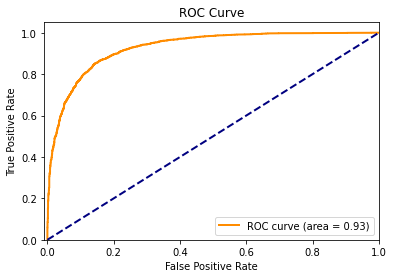

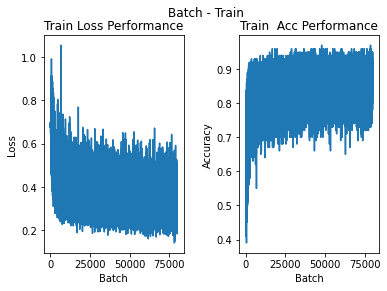

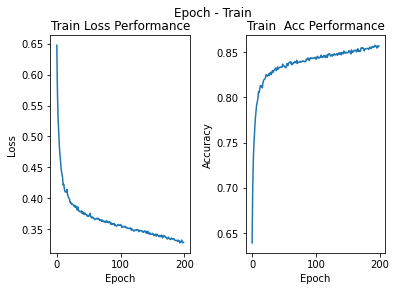

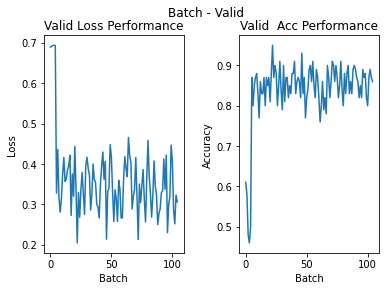

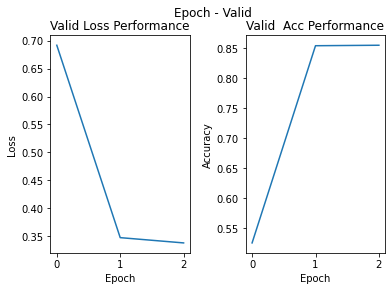

In [78]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn import preprocessing

# from platiagro import save_figure
# from platiagro import list_figures
from sklearn.metrics import auc, roc_curve

y_pred = list(model.df_test["PREDICTED_CODE"])
y_prob = [
    [a, b]
    for a, b in zip(list(model.df_test["NEG_PROBA"]), list(model.df_test["POS_PROBA"]))
]


def plot_roc_curve(y_test, y_prob, labels):
    n_classes = len(labels)
    y_test = list(y_test)
    y_prob = np.array(y_prob)

    if n_classes == 2:
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)

        # Plot ROC Curve
        plt.figure()
        lw = 2
        plt.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc,
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

    else:
        # Binarize the output
        lb = preprocessing.LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)

        # Compute ROC curve for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        color = cm.rainbow(np.linspace(0, 1, n_classes + 1))
        plt.figure()
        lw = 2
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")

        for i, c in zip(range(n_classes), color):
            plt.plot(
                fpr[i],
                tpr[i],
                color=c,
                lw=lw,
                label="ROC curve - Class %s (area = %0.2f)" % (labels[i], roc_auc[i]),
            )
            plt.title("ROC Curve One-vs-Rest")
            plt.legend(loc="lower right")

        plt.show()


# funciona apenas quando se treina o modelo, quando recupera os pesos aparentemente não está
def performance_visualization(
    loss_list, acc_list, epoch_or_batch="Epoch", step="Train"
):

    x = range(len(loss_list))
    plt.title(step + " Loss Performance")

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.xlabel(epoch_or_batch)
    plt.ylabel("Loss")
    plt.plot(x, loss_list, "-")
    plt.title(step + " Loss Performance")

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.xlabel(epoch_or_batch)
    plt.ylabel("Accuracy")
    plt.plot(x, acc_list, "-")
    plt.title(step + "  Acc Performance")

    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(epoch_or_batch + " - " + step)
    plt.show()


plot_roc_curve(y_test, y_prob, labels)
if not weights_retrieved:
    performance_visualization(
        model.df_performance_train_batch["train_batch_loss"].to_numpy(),
        model.df_performance_train_batch["train_batch_acc"].to_numpy(),
        epoch_or_batch="Batch",
        step="Train",
    )
    performance_visualization(
        model.df_performance_train_epoch["train_epoch_loss"].to_numpy(),
        model.df_performance_train_epoch["train_epoch_acc"].to_numpy(),
        epoch_or_batch="Epoch",
        step="Train",
    )
    performance_visualization(
        model.df_performance_valid_batch["valid_batch_loss"].to_numpy(),
        model.df_performance_valid_batch["valid_batch_acc"].to_numpy(),
        epoch_or_batch="Batch",
        step="Valid",
    )
    performance_visualization(
        model.df_performance_valid_epoch["valid_epoch_loss"].to_numpy(),
        model.df_performance_valid_epoch["valid_epoch_acc"].to_numpy(),
        epoch_or_batch="Epoch",
        step="Valid",
    )

## Salva modelo e outros artefatos

Modelo Pytorch Lightining

In [67]:
file_name = "pytorch_model.pt"
torch.save(model.state_dict(), f"/tmp/data/{file_name}")

Artefatos

In [69]:
import pickle

dataset_infos = {"all_data": all_data}
deployment_infos = {"columns": columns, "X_test": X_test, "glove_vocab": glove_vocab}
artifacts = {
    "hyperparams": hyperparams,
    "model_parameters": model_parameters,
    "dataset_infos": dataset_infos,
    "extra_infos": extra_infos,
    "deployment_infos": deployment_infos,
}
file_name = "artifacts.p"
pickle.dump(artifacts, open(f"/tmp/data/{file_name}", "wb"))